In [1]:
%load_ext autoreload
%autoreload 2

In [14]:
import australia
import models
import mscthesis
import pandas as pd
import geopandas as gpd
import validation
import numpy as np
import datetime
import genericvalidation
import matplotlib.pyplot as plt

In [3]:
sampler = models.Sampler(
    model=models.PreferentialReturn(
        p=0.2,
        gamma=0.8,
        region_sampling=models.RegionTransitionZipf(
            beta=0.05,
        ),
        jump_size_sampling=models.JumpSizeTrueProb(),
    ),
    daily_trips_sampling=models.NormalDistribution(3.14, 1.8),
    n_days=7*20,
    geotweets_path="",
)

In [335]:
geotweets = mscthesis.read_geotweets_raw("../../dbs/australia/geotweets.csv").set_index('userid')

# Only look at weekday trips
geotweets = geotweets[(geotweets['weekday'] < 6) & (0 < geotweets['weekday'])]

# Remove users who don't have home visit in geotweets
home_visits = geotweets.query("label == 'home'").groupby('userid').size()
geotweets = geotweets.loc[home_visits.index]

# Remove users with less than 20 tweets
tweetcount = geotweets.groupby('userid').size()
geotweets = geotweets.drop(labels=tweetcount[tweetcount < 20].index)

# Remove users with only one region
regioncount = geotweets.groupby(['userid', 'region']).size().groupby('userid').size()
geotweets = geotweets.drop(labels=regioncount[regioncount < 2].index)

# Ensure the tweets are sorted chronologically
geotweets = geotweets.sort_values(by=['userid', 'createdat'])

In [336]:
geotweets.shape

(601369, 12)

In [337]:
baseline = models.geotweets_to_visits(geotweets)

In [332]:
geotweetsx = geotweets.loc[geotweets.groupby('userid').size()[:10].index]

In [338]:
print(datetime.datetime.now())
visits = sampler.sample(geotweets)
print(datetime.datetime.now())

2020-04-22 18:46:17.661057
IPF converged after 7 iterations
IPF converged after 4 iterations
IPF converged after 11 iterations
IPF converged after 10 iterations
IPF converged after 11 iterations
IPF converged after 3 iterations
IPF converged after 3 iterations
IPF converged after 8 iterations
IPF converged after 19 iterations
IPF converged after 4 iterations
IPF converged after 14 iterations
IPF converged after 11 iterations
IPF converged after 23 iterations
IPF converged after 9 iterations
IPF converged after 9 iterations
IPF converged after 20 iterations
IPF converged after 3 iterations
IPF converged after 5 iterations
IPF converged after 3 iterations
IPF converged after 3 iterations
IPF converged after 12 iterations
IPF converged after 12 iterations
IPF converged after 8 iterations
IPF converged after 9 iterations
IPF converged after 24 iterations
IPF converged after 8 iterations
IPF converged after 4 iterations
IPF converged after 15 iterations
IPF converged after 5 iterations
IPF 

IPF converged after 17 iterations
IPF converged after 2 iterations
IPF converged after 27 iterations
IPF converged after 17 iterations
IPF converged after 19 iterations
done with 250
IPF converged after 4 iterations
IPF converged after 2 iterations
IPF converged after 9 iterations
IPF converged after 5 iterations
IPF converged after 17 iterations
IPF converged after 14 iterations
IPF converged after 6 iterations
IPF converged after 21 iterations
IPF converged after 6 iterations
IPF converged after 3 iterations
IPF converged after 44 iterations
IPF converged after 9 iterations
IPF converged after 22 iterations
IPF converged after 8 iterations
IPF converged after 9 iterations
IPF converged after 13 iterations
IPF converged after 3 iterations
IPF converged after 3 iterations
IPF converged after 37 iterations
IPF converged after 9 iterations
IPF converged after 1 iterations
IPF converged after 9 iterations
IPF converged after 16 iterations
IPF converged after 21 iterations
IPF converged af

IPF converged after 7 iterations
IPF converged after 6 iterations
IPF converged after 5 iterations
IPF converged after 3 iterations
IPF converged after 11 iterations
IPF converged after 9 iterations
IPF converged after 4 iterations
IPF converged after 19 iterations
IPF converged after 10 iterations
IPF converged after 3 iterations
done with 500
IPF converged after 12 iterations
IPF converged after 19 iterations
IPF converged after 3 iterations
IPF converged after 4 iterations
IPF converged after 11 iterations
IPF converged after 27 iterations
IPF converged after 8 iterations
IPF converged after 7 iterations
IPF converged after 21 iterations
IPF converged after 37 iterations
IPF converged after 3 iterations
IPF converged after 4 iterations
IPF converged after 6 iterations
IPF converged after 26 iterations
IPF converged after 3 iterations
IPF converged after 8 iterations
IPF converged after 3 iterations
IPF converged after 6 iterations
IPF converged after 9 iterations
IPF converged after

IPF converged after 6 iterations
IPF converged after 3 iterations
IPF converged after 13 iterations
IPF converged after 3 iterations
IPF converged after 4 iterations
IPF converged after 3 iterations
IPF converged after 3 iterations
IPF converged after 16 iterations
IPF converged after 8 iterations
IPF converged after 4 iterations
IPF converged after 12 iterations
IPF converged after 28 iterations
IPF converged after 9 iterations
IPF converged after 14 iterations
IPF converged after 16 iterations
done with 750
IPF converged after 11 iterations
IPF converged after 13 iterations
IPF converged after 15 iterations
IPF converged after 12 iterations
IPF converged after 15 iterations
IPF converged after 5 iterations
IPF converged after 3 iterations
IPF converged after 4 iterations
IPF converged after 3 iterations
IPF converged after 12 iterations
IPF converged after 4 iterations
IPF converged after 8 iterations
IPF converged after 9 iterations
IPF converged after 16 iterations
IPF converged af

IPF converged after 4 iterations
IPF converged after 5 iterations
IPF converged after 15 iterations
IPF converged after 4 iterations
IPF converged after 5 iterations
IPF converged after 13 iterations
IPF converged after 17 iterations
IPF converged after 18 iterations
IPF converged after 2 iterations
IPF converged after 3 iterations
IPF converged after 4 iterations
IPF converged after 7 iterations
IPF converged after 29 iterations
IPF converged after 12 iterations
IPF converged after 42 iterations
IPF converged after 14 iterations
IPF converged after 15 iterations
IPF converged after 8 iterations
IPF converged after 3 iterations
IPF converged after 3 iterations
done with 1000
IPF converged after 14 iterations
IPF converged after 7 iterations
IPF converged after 2 iterations
IPF converged after 3 iterations
IPF converged after 3 iterations
IPF converged after 3 iterations
IPF converged after 5 iterations
IPF converged after 5 iterations
IPF converged after 9 iterations
IPF converged afte

IPF converged after 16 iterations
IPF converged after 14 iterations
IPF converged after 17 iterations
IPF converged after 11 iterations
IPF converged after 4 iterations
IPF converged after 12 iterations
IPF converged after 14 iterations
IPF converged after 15 iterations
IPF converged after 3 iterations
IPF converged after 4 iterations
IPF converged after 5 iterations
IPF converged after 16 iterations
IPF converged after 3 iterations
IPF converged after 6 iterations
IPF converged after 7 iterations
IPF converged after 27 iterations
IPF converged after 5 iterations
IPF converged after 20 iterations
IPF converged after 11 iterations
IPF converged after 17 iterations
IPF converged after 3 iterations
IPF converged after 9 iterations
IPF converged after 35 iterations
IPF converged after 3 iterations
IPF converged after 24 iterations
done with 1250
IPF converged after 3 iterations
IPF converged after 29 iterations
IPF converged after 12 iterations
IPF converged after 24 iterations
IPF converg

IPF converged after 30 iterations
IPF converged after 3 iterations
IPF converged after 7 iterations
IPF converged after 36 iterations
IPF converged after 8 iterations
IPF converged after 2 iterations
IPF converged after 7 iterations
IPF converged after 8 iterations
IPF converged after 6 iterations
IPF converged after 32 iterations
IPF converged after 2 iterations
IPF converged after 12 iterations
IPF converged after 20 iterations
IPF converged after 23 iterations
IPF converged after 9 iterations
IPF converged after 14 iterations
IPF converged after 17 iterations
IPF converged after 6 iterations
IPF converged after 7 iterations
IPF converged after 9 iterations
IPF converged after 24 iterations
IPF converged after 13 iterations
IPF converged after 23 iterations
IPF converged after 4 iterations
IPF converged after 12 iterations
IPF converged after 23 iterations
IPF converged after 28 iterations
IPF converged after 3 iterations
IPF converged after 3 iterations
IPF converged after 4 iterati

IPF converged after 10 iterations
IPF converged after 12 iterations
IPF converged after 4 iterations
IPF converged after 13 iterations
IPF converged after 11 iterations
IPF converged after 2 iterations
IPF converged after 4 iterations
IPF converged after 2 iterations
IPF converged after 31 iterations
IPF converged after 12 iterations
IPF converged after 21 iterations
IPF converged after 8 iterations
IPF converged after 3 iterations
IPF converged after 14 iterations
IPF converged after 21 iterations
IPF converged after 4 iterations
IPF converged after 2 iterations
IPF converged after 3 iterations
IPF converged after 7 iterations
IPF converged after 8 iterations
IPF converged after 35 iterations
IPF converged after 14 iterations
IPF converged after 6 iterations
IPF converged after 12 iterations
IPF converged after 10 iterations
IPF converged after 7 iterations
IPF converged after 7 iterations
IPF converged after 6 iterations
IPF converged after 14 iterations
IPF converged after 6 iterati

IPF converged after 10 iterations
IPF converged after 4 iterations
IPF converged after 2 iterations
IPF converged after 3 iterations
IPF converged after 14 iterations
IPF converged after 25 iterations
IPF converged after 18 iterations
IPF converged after 10 iterations
IPF converged after 7 iterations
IPF converged after 6 iterations
IPF converged after 6 iterations
IPF converged after 3 iterations
IPF converged after 11 iterations
IPF converged after 19 iterations
IPF converged after 6 iterations
IPF converged after 17 iterations
IPF converged after 8 iterations
IPF converged after 9 iterations
IPF converged after 7 iterations
IPF converged after 20 iterations
IPF converged after 17 iterations
IPF converged after 19 iterations
IPF converged after 13 iterations
IPF converged after 13 iterations
IPF converged after 8 iterations
IPF converged after 15 iterations
IPF converged after 6 iterations
IPF converged after 2 iterations
IPF converged after 10 iterations
IPF converged after 3 iterat

IPF converged after 16 iterations
IPF converged after 5 iterations
IPF converged after 23 iterations
IPF converged after 8 iterations
IPF converged after 4 iterations
IPF converged after 18 iterations
IPF converged after 7 iterations
IPF converged after 3 iterations
IPF converged after 5 iterations
IPF converged after 6 iterations
IPF converged after 2 iterations
IPF converged after 34 iterations
IPF converged after 5 iterations
IPF converged after 4 iterations
IPF converged after 3 iterations
IPF converged after 3 iterations
IPF converged after 6 iterations
IPF converged after 13 iterations
IPF converged after 20 iterations
IPF converged after 3 iterations
IPF converged after 20 iterations
IPF converged after 11 iterations
IPF converged after 5 iterations
IPF converged after 19 iterations
IPF converged after 7 iterations
IPF converged after 6 iterations
IPF converged after 19 iterations
IPF converged after 2 iterations
IPF converged after 20 iterations
IPF converged after 3 iterations

IPF converged after 18 iterations
IPF converged after 17 iterations
IPF converged after 7 iterations
IPF converged after 20 iterations
IPF converged after 4 iterations
IPF converged after 18 iterations
IPF converged after 6 iterations
IPF converged after 6 iterations
IPF converged after 5 iterations
IPF converged after 24 iterations
IPF converged after 4 iterations
IPF converged after 6 iterations
IPF converged after 7 iterations
IPF converged after 6 iterations
IPF converged after 10 iterations
IPF converged after 30 iterations
IPF converged after 21 iterations
IPF converged after 17 iterations
IPF converged after 3 iterations
IPF converged after 16 iterations
IPF converged after 9 iterations
IPF converged after 13 iterations
IPF converged after 9 iterations
IPF converged after 17 iterations
IPF converged after 3 iterations
IPF converged after 10 iterations
IPF converged after 10 iterations
IPF converged after 12 iterations
IPF converged after 2 iterations
IPF converged after 7 iterat

IPF converged after 3 iterations
IPF converged after 6 iterations
IPF converged after 6 iterations
IPF converged after 34 iterations
IPF converged after 3 iterations
IPF converged after 8 iterations
IPF converged after 3 iterations
IPF converged after 3 iterations
IPF converged after 4 iterations
IPF converged after 12 iterations
IPF converged after 5 iterations
IPF converged after 5 iterations
IPF converged after 5 iterations
IPF converged after 8 iterations
IPF converged after 16 iterations
IPF converged after 16 iterations
IPF converged after 16 iterations
IPF converged after 18 iterations
IPF converged after 7 iterations
IPF converged after 3 iterations
IPF converged after 14 iterations
IPF converged after 3 iterations
IPF converged after 22 iterations
IPF converged after 3 iterations
IPF converged after 11 iterations
IPF converged after 2 iterations
IPF converged after 33 iterations
IPF converged after 4 iterations
IPF converged after 5 iterations
IPF converged after 3 iterations


In [356]:
visits.to_csv('./../../dbs/australia/visits.csv')

In [340]:
zones = australia.validation_zones()
hts = australia.validation_travel_survey()

In [341]:
home_locations = pd.read_csv('../../dbs/australia/homelocations.csv')
home_locations = gpd.GeoDataFrame(
    home_locations,
    crs="EPSG:4326",
    geometry=gpd.points_from_xy(home_locations.longitude, home_locations.latitude),
).to_crs(zones.crs)

In [342]:
zone_to_user = gpd.sjoin(home_locations, zones)[['zone', 'userid']]

In [349]:
def prepare_travel_survey(hts):
    hts = hts[['WAVE', 'zone', 'WEIGHTED_TRIPS', 'WEIGHTED_TOTAL_DISTANCE']].groupby(['WAVE', 'zone']).sum()
    hts = hts.WEIGHTED_TOTAL_DISTANCE / hts.WEIGHTED_TRIPS 
    hts = hts.loc['2018/19']
    return hts


def visits_to_trips(visits):
    def trip_dist(t):
        return mscthesis.haversine_distance(
            t.latitude_origin, t.longitude_origin, 
            t.latitude_destination, t.longitude_destination,
        )
    print("converting to trips")
    trips = mscthesis.visit_gaps(visits)
    print("calculating distances")
    trip_dists = trips.apply(trip_dist, axis=1)
    return trip_dists

def summarize_trips_per_zone(trips, user_zone):
    trip_summaries = pd.DataFrame.from_dict(dict(
        num_trips = trips.groupby('userid').size(),
        total_distance = trips.groupby('userid').sum(),
    ))
    zone_trips = user_zone.merge(trip_summaries, on='userid')
    zone_trips = zone_trips.groupby('zone').sum()
    zone_avg_distance = zone_trips.total_distance / zone_trips.num_trips
    return zone_avg_distance
    

In [344]:
groundtruth_avg_distance = prepare_travel_survey(hts)

In [351]:
model_trips = visits_to_trips(visits)
model_avg_distance = summarize_trips_per_zone(model_trips, zone_to_user)
model_avg_distance = model_avg_distance.reindex(groundtruth_avg_distance.index, fill_value=0)

converting to trips
calculating distances


In [354]:
baseline_trips = visits_to_trips(baseline)
baseline_avg_distance = summarize_trips_per_zone(baseline_trips, zone_to_user)
baseline_avg_distance = baseline_avg_distance.reindex(groundtruth_avg_distance.index, fill_value=0)

converting to trips
calculating distances


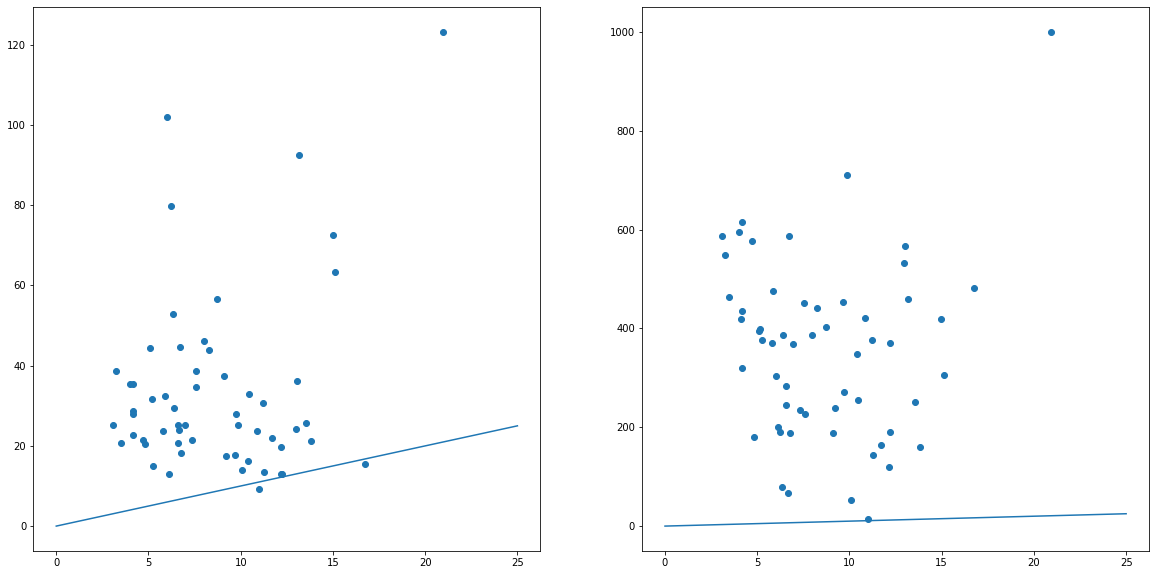

In [355]:
fig, axes = plt.subplots(1,2, figsize=(20,10))

axes[0].scatter(x=groundtruth_avg_distance, y=model_avg_distance)
axes[0].plot([0, 25], [0,25])
axes[1].scatter(x=groundtruth_avg_distance, y=baseline_avg_distance)
axes[1].plot([0, 25], [0,25])

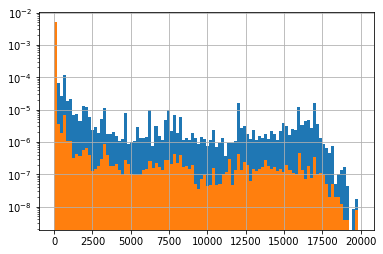

In [375]:
ax = baseline_trips.hist(log=True, bins=100, density=True)
model_trips.hist(ax=ax,log=True, bins=100, density=True)

AssertionError: passed axis not bound to passed figure

<Figure size 432x288 with 0 Axes>